# Phase 3 Data Science Report

In [3]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from functions import* 

hypermodel = tf.keras.models.load_model('output/my_model')

# Introduction

It is of interest to have a model that is able determine the probability that there is mentioned item or animal. In order to build this model, CIFAR-10 dataset is initially provided which consists of 60000 32x32 colour images in 10 different classes. This dataset will be then fed in tensorflow keras model that uses neural network to recognise underlying relationships in a set of data.

# Model Process

Using CIFAR-10 dataset, 40000 training and 8000 test images are attained, each containing same number of images in each class. This is to avoid class imbalance in dataset which can later cause accuracy issue of the model. Each class follows as shown below.

* airplane
* automobile
* bird
* cat
* deer
* dog
* rog
* horse
* ship
* truck 

There are several layers that needs to be specified in the keras model before passing through the training set. 

Firstly, keras preprocessing layers such as RandomFlip, RandomRotation, and RandomZoom are used to implement data augmentation. This takes the approach of generating additional training data from existing images by augmenting them using random transformations. This helps expose the model to more aspects of the data and generalize better (prevents overfitting). The image of cat is augmented several time to visualise the effect as shown below.

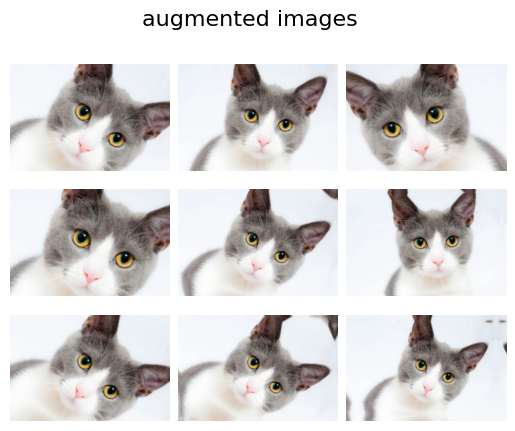

In [10]:
Image.open('image/cat_augmented_image.png')


Next layers applied to the keras model are Conv2D and MaxPooling2D. The convolution layer extracts certain features from an input image. And then pooling layer is used to reduce the spatial dimension of generated feaures. This approach allows to create a lower resolution version of image input that still contains the important features, without the fine detail that may not be as useful to the task. The model summary below show how shape changes over each layers.

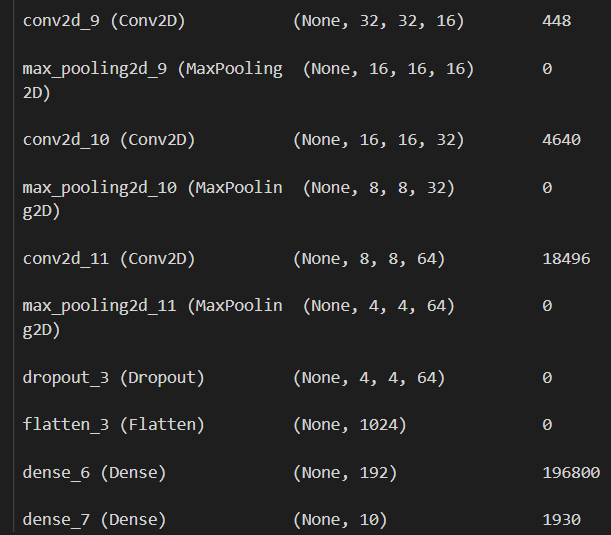

In [8]:
Image.open('image/layers.png')

The dropout layer is another technique to reduce overfitting by introducing dropout reglarization to the network (Nitish Srivastava, et al. 2014). This layer does not alter the shape of output but instead it removes a number of output units from the layer during the training process. 

Finally, network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) and passes through dense layers to get 10 output class which corresponds to the number of classes in test and training image.

Once the layer set up for keras model is completed, the training images can fed into the model. However, it was very confusing which parameters are appropriate for some layers such as units in dense layer, droupout ratio and learning rate of the model. One well known solution to this is hyperparameter tuning that is choosing a set of optimial parameters for training the model. Since, the goal of this project is to build the model that is able to accurately predict presence of chosen label from any images, the objective of hyperparameter tuning is set to validation accuracy. The result below was attained, using keras Hyperband Tuner.

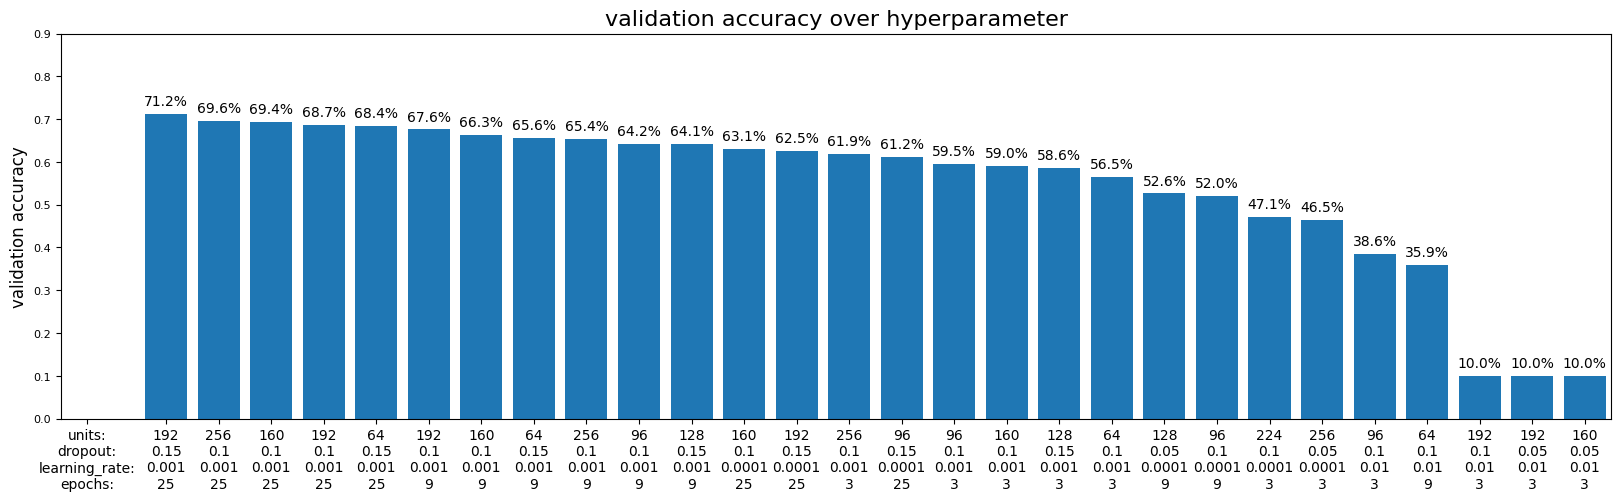

In [11]:
Image.open('image/hypertune.png')

Hyperparamer tuning was very time consuming procedure as it uses range use parameter values to find optimal parameter. To make more efficient use of Hyperband Tuner, the maximum number of training iteration is set to 25 with stopping criteria if the model validation accuracy is not improving quickly enough. In this way, 192 for units, 0.15 for dropout ratio and 0.001 for learning rate are attained as optimal parameter for setting up keras model. 

The model is then trained again with full training iteration to study the behavior of accuracy/loss and validation accuracy/loss. 

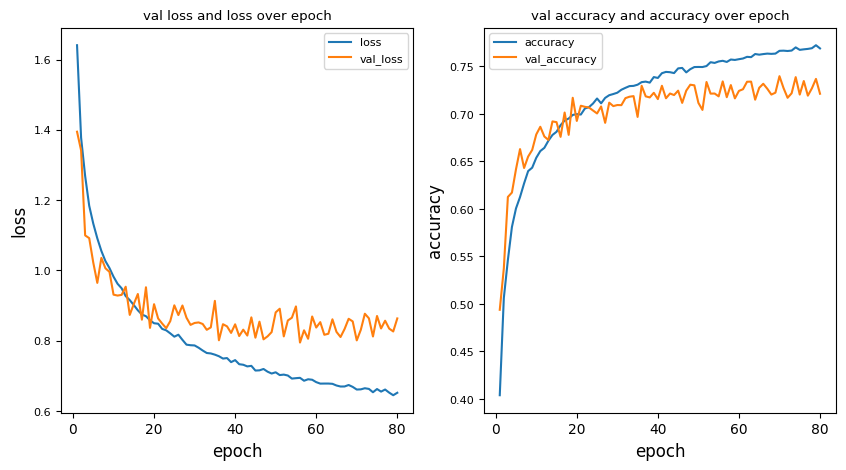

In [13]:
Image.open('image/accuracylossplot.png')

It is noticeable that validation loss and accuracy start peaking(down and up) at value of around 60 epoch. At this point, it is good to stop the training iteration and maximum validaton accuracy is recorded at epoch of 70. The model accuracy and loss are continuously improving which is a good example of overfitting the model. Finally, the model is trained again with epoch of 70.

# Model Performance

In [14]:
test_labels,test_images=load_test_data()
# result
eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

NameError: name 'test_images' is not defined

# Conclusion

# References

1. [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer,), Nitish Srivastava, et al. 2014.